In [2]:
from google.colab import drive
import pickle
import pandas as pd
import numpy as np
import re      
import string   
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.decomposition import NMF 
from wordcloud import WordCloud
import matplotlib.pylab as plt
!pip install langdetect
from langdetect import detect, DetectorFactory 
from collections import defaultdict
import nltk 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 4.1 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=0138eb98ae25212e221154cf4e988b55130ff18030703724ec6804b2b71fdad7
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
drive.mount('/content/drive', force_remount=True)

pd.set_option('display.max_rows', 30)

Mounted at /content/drive


**Imports from CSV and pickles.**

In [5]:
direccion_raiz = '/content/drive/My Drive/Data'

producto_disciplina = pd.read_csv(direccion_raiz + '/producto_disciplina.csv', sep = ";")
produccion_cientifica = pd.read_pickle(direccion_raiz + '/produccion_cientifica.pkl')
disciplinas = pd.read_pickle(direccion_raiz + '/disciplinas.pkl')
# producto_persona_funcion = pd.read_pickle(direccion_raiz + '/producto_persona_funcion.pkl')
# personas_total = pd.read_pickle(direccion_raiz + '/personas_total.pkl')
# personas = pd.read_pickle(direccion_raiz + '/personas.pkl')


**An insight of those DF. Our final Data Frame will have the resumes of all the papers in every year from every discipline (broad range) in english.**

In [ ]:
producto_disciplina.head(3)   # Connects Id products with Id disciplines

,producto_id,disciplina_id
0,1,51
1,1,269
2,1,258


In [ ]:
disciplinas.head(3)     # Explains disciplines in a broad range. We will focus on 'gran_area_descripcion', the more general discipline range

,disciplina_id,gran_area_codigo,gran_area_descripcion,area_codigo,area_descripcion,disciplina_codigo,disciplina_descripcion
0,-1,-1,SIN DATOS,-1.0,SIN DATOS,-1,SIN DATOS
1,1,1,CIENCIAS NATURALES Y EXACTAS,1.0,SIN DATOS,1.0.0,SIN DATOS
2,2,1,CIENCIAS NATURALES Y EXACTAS,1.1,Matemáticas,1.1.0,SIN DATOS


In [ ]:
produccion_cientifica.head(3)   # Shows all the 'producto_id': papers, books's chapters and books. 
                                # For this program we choose only papers ('tipo_produccion_id' == 1)

,producto_id,tipo_produccion_id,idioma_id,anio_publica,titulo,resumen,palabras_clave
0,358,1,4.0,2011,Tasseled Cap potential for age monitoring in S...,"At a landscape scale, remote sensing becomes a...",REMOTE SENSING|LANDSAT|MONITORING|TASSELED CAP
1,1096,1,4.0,2011,Reconciling pre-Columbian settlement hypothese...,Reconciling pre-Columbian settlement hypothese...,pre-Columbian settlement
2,1219,1,5.0,2011,?Predicción de la duración de la carrera de Ag...,El objetivo de este trabajo es construir un mo...,Duración de estudios universitarios|Rendimient...


In [ ]:
# Merges to get title of 'gran_area_descripcion' instead its Id

producto_id_disciplina_titulo = producto_disciplina.merge(disciplinas, on='disciplina_id')[['producto_id', 'gran_area_descripcion']]
producto_id_disciplina_titulo.head(3)

,producto_id,gran_area_descripcion
0,1,CIENCIAS NATURALES Y EXACTAS
1,22,CIENCIAS NATURALES Y EXACTAS
2,49,CIENCIAS NATURALES Y EXACTAS


In [ ]:
# Merges and gets a DF with the resume (resumen), disciplie (gran_area_descripcion), year (anio_publica) and type of product == 'paper'(tipo_produccion_id==1).
# In every language

df_all_language_all_products = produccion_cientifica.merge(producto_id_disciplina_titulo, how='left', on='producto_id')
df_all_language = df_all_language_all_products[df_all_language_all_products['tipo_produccion_id']==1][['anio_publica', 'resumen', 'gran_area_descripcion']]
df_all_language.head(3)

,anio_publica,resumen,gran_area_descripcion
0,2011,"At a landscape scale, remote sensing becomes a...",CIENCIAS NATURALES Y EXACTAS
1,2011,Reconciling pre-Columbian settlement hypothese...,CIENCIAS NATURALES Y EXACTAS
2,2011,El objetivo de este trabajo es construir un mo...,CIENCIAS NATURALES Y EXACTAS


In [ ]:
# Detects language and create an 'english' filter

def filter_eng(a):                    
  try:
    DetectorFactory.seed = 0
    ko = detect(a)
    if (ko == 'en'):
      return True
    else:
      return False
  except:
    return False

In [ ]:
df = df_all_language[df_all_language['resumen'].apply(filter_eng)]  # We filter only english language and reach the final DataFrame
df.head(3)

,anio_publica,resumen,gran_area_descripcion
0,2011,"At a landscape scale, remote sensing becomes a...",CIENCIAS NATURALES Y EXACTAS
1,2011,Reconciling pre-Columbian settlement hypothese...,CIENCIAS NATURALES Y EXACTAS
3,2011,Arsenic is an abundant toxic metal in our envi...,CIENCIAS NATURALES Y EXACTAS


In [ ]:
# Comment para guardar y cargar DF ingles papers

# pd.DataFrame(data=df).to_pickle('/content/drive/My Drive/CV Portfolio/Data/df_eng.pkl') 
# hola = pd.read_pickle('/content/drive/My Drive/CV Portfolio/Data/df_eng.pkl')

**Adds stopwords from a txt file and add more based several runs of the program.**

In [ ]:
f = open(direccion_raiz + '/stopwords_english.txt','r')           # Reads english stopwords from a Github list.  ['hence\n', 'heterogeneity\n',... etc
contents = f.readlines()
f.close()

stopwords_english = []                # Creates a list with 'contents' without '\n'
for a in range(len(contents)):
  stopwords_english.append(contents[a][:-1])

extra_sw_1 = ['nbsp', 'de', 'la', 'en', 'el', 'de la', 'los', 'que', 'se', 'del',                                   # extra stopwords added after running
                    'mso', 'font', 'font family', 'amp', 'amp amp', 'family', 'mso font', 'font size', 'msonormal', # the code 
                    '±', '0cm', 'charset', 'wordsection1', '95', 'kg', 'soc', 'gev', 'tev', 'sp', 'µg', 'mg', 'g', 'ml', 'p' ]

extra_sw_2 = ['pdf',  'ver',  'adjunto',  'archivo',  'texto',  'completo',  'full',  'resumen',  'posee',  'capitulo',  'editorial',
  'nota',  'anexo',  'trabajo',  'line',  'articulo',  'publicacion',  'adjunta',  'pubmed',  'abajo',  'seccion',  'attachment',  'declarado',
  'detalla',  'seccion',  'web',  'publicado',  'aa',  'bb',  'ab',  'and',  "nan",  "httpdxdoiorgjbbr",  "httpdxdoiorgjlmot",  "httpdxdoiorgjphysbeh",
  "nn",  "age",  "km",  "yr",  "bp",  "eel",  "ru",  "economy",  "yhm",  "ol",  "sr",  "mrsa",  "il",  "one",  "cd",  "james",  "economic"]                  


lemmatizer = WordNetLemmatizer()              # Initialize the lemmatizer
nltk.download('stopwords')                    # Downloads stopwords from ntlk
stopwords = nltk.corpus.stopwords.words('english') + stopwords_english + extra_sw_1 + extra_sw_2  # Creates a master stopword list with contents
                                                                                                  # extra_sw_1, extra_sw_2 y ntlk stopwords
stopwords = list(set(stopwords))              # Erase duplicates                                                                                              

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Lemmatization functions**

In [ ]:
def lemmatization(text):
  words = word_tokenize(text)     # Tokenizes text
  words_clean = []
  for w in words:
    if not w in stopwords:        # Filters stopwords
      words_clean.append(lemmatizer.lemmatize(w)) # Lemmatize
  return ' '.join(words_clean)

def lemma(a):                     # Calls lemmatization function 
  lematizado = []
  for n,i in enumerate(a):
    lematizado.append(lemmatization(i))
  return lematizado

**Applies text filtering.**

In [ ]:
def filter_str_basic(text):
    text = text.lower()                                              
    text = re.sub('\[.*?¿\]\%', '', text)                           
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    text = re.sub('\w*\d\w*', '', text)     
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\t', '', text)
    text = re.sub("two","", text) 
    text = re.sub("cells","", text) 
    text = re.sub("eq","", text) 
    return text

In [ ]:
lista_resumen_disciplinas= ['CIENCIAS NATURALES Y EXACTAS', 'CIENCIAS MÉDICAS Y DE LA SALUD', 'INGENIERÍAS Y TECNOLOGÍAS', # List of disciplines to filter
                           'CIENCIAS AGRÍCOLAS', 'CIENCIAS SOCIALES', 'HUMANIDADES']


# Creates a dict
# For each discipline from the 'lista_resumen_disciplinas' applys 'filter_str_basic and then 'lemma'. 
# Then saves on  dict with discipline as key.

dict_resumen_disciplinas_papers= {}           
for disciplina in lista_resumen_disciplinas:                                            
  dict_resumen_disciplinas_papers[disciplina] = lemma(df[df['gran_area_descripcion']==disciplina]['resumen'].apply(filter_str_basic))

**Plots a Word Cloud based on  NMF topic detection.**

In [ ]:
def nmf_wordcloud(resumen_dict,n_components):

  count = CountVectorizer(min_df = 2, max_df = 0.70, stop_words = stopwords)  # Ignores terms that appear only in one document and those who repeats in more than 70% of the documents. 
                                                                              # Removes the stopwords too.
  for key, value in resumen_dict.items():
    
    x_count = count.fit_transform(value)    # Tokenizes
    tfidf = TfidfTransformer(norm = 'l2')
    x_tfidf = tfidf.fit_transform(x_count)  # Creates term frequency - inverse document frequency to scale down the weight of tokens that appear in many documents, hence less informative.
    nmf = NMF(n_components = n_components)
    x_nmf = nmf.fit_transform(x_tfidf)      # Creates the Non-negative Matrix Factorization

    vocabulary = {item: key for key, item in count.vocabulary_.items()}

    wc_atributos = {'height' : 800,         # Sets the design options of the wordcloud
                      'width' : 1200,
                      'background_color' : 'white',
                      'max_words' : 20
                      } 
    fig, axs = plt.subplots( ncols=n_components, figsize = (25,10))

    print(f'\n\n----------> {key} <----------')
        
    for n in range(n_components):    

      list_sorted = sorted(range(len(vocabulary)), reverse = True, key = lambda x: nmf.components_[n][x])[:10]

      comp_dict = {vocabulary[i]: nmf.components_[n][i] for i in list_sorted}

      wc = WordCloud(**wc_atributos 
                    ).generate_from_frequencies(comp_dict)

      axs[n].set_title('Topic {}'.format(n))
      axs[n].imshow(wc)
      axs[n].axis('off')
      
      cont=0
      for key2, value2 in comp_dict.items():
        if (cont < 3):
          dict_key_nmf[key].append(key2)
          cont= cont+1
      
    plt.show()

In [ ]:
list_resumen_anios = [2011, 2012, 2013, 2014, 2015, 2017] # List of years to filter

# Creates a dict.
# For each year from the 'list_resumen_anios' applys 'filter_str_basic and then 'lemma'. 
# Then saves on the dict with discipline as key.

dict_resumen_anios_papers ={}
for anio in list_resumen_anios:                                                        
  dict_resumen_anios_papers[anio] = lemma(df[df['anio_publica']==anio]['resumen'].apply(filter_str_basic))

**Plots the Word Cloud based on topic by NMF detection for each discipline and sorted by weight. 'Topic 0' beeing the most heavy topic, we have an idea about towards what direction most of the paper in english where pointing at in that particular discipline.**



----------> CIENCIAS NATURALES Y EXACTAS <----------


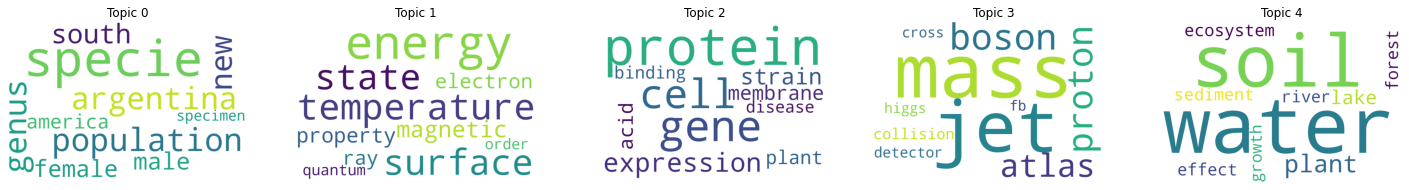



----------> CIENCIAS MÉDICAS Y DE LA SALUD <----------


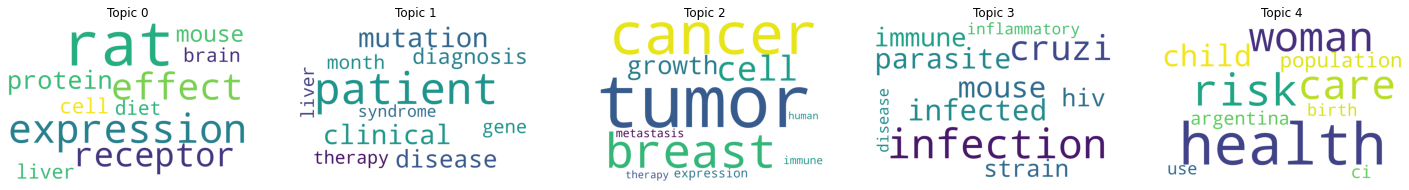



----------> INGENIERÍAS Y TECNOLOGÍAS <----------


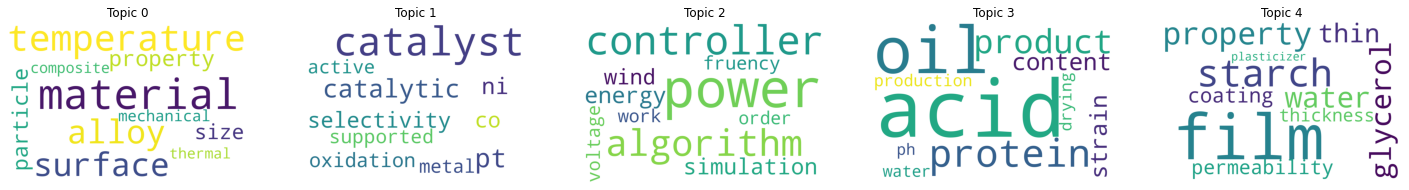



----------> CIENCIAS AGRÍCOLAS <----------


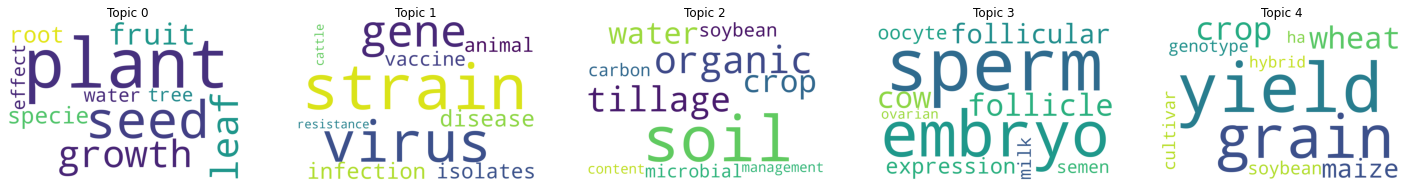



----------> CIENCIAS SOCIALES <----------


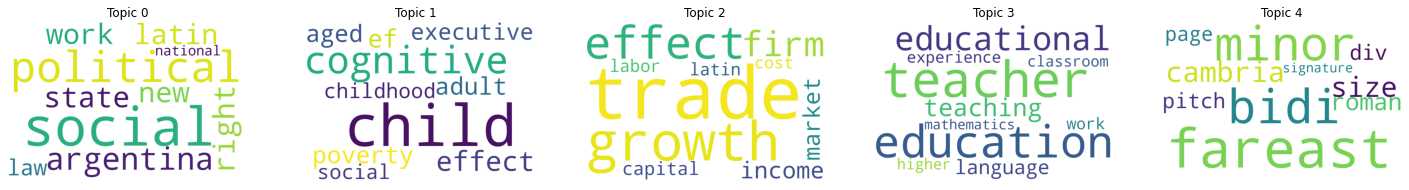



----------> HUMANIDADES <----------


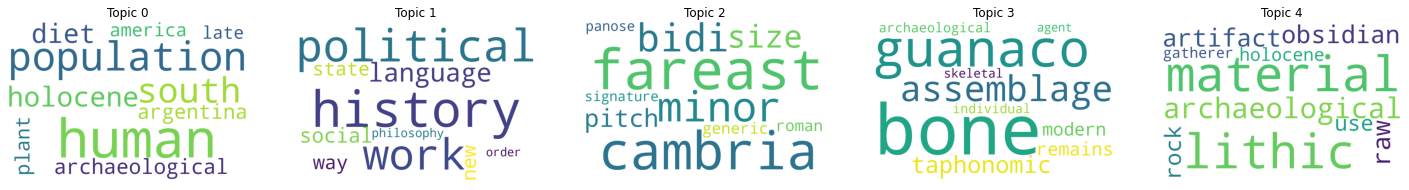

In [ ]:
dict_key_nmf = defaultdict(list)
nmf_wordcloud(dict_resumen_disciplinas_papers, 5)

**Plots the Word Cloud based on topic by NMF detection for each year and sorted by weight. 'Topic 0' beeing the most heavy topic, we have an idea about towards what direction most of the paper in english where pointing at in those years.**



----------> 2011 <----------


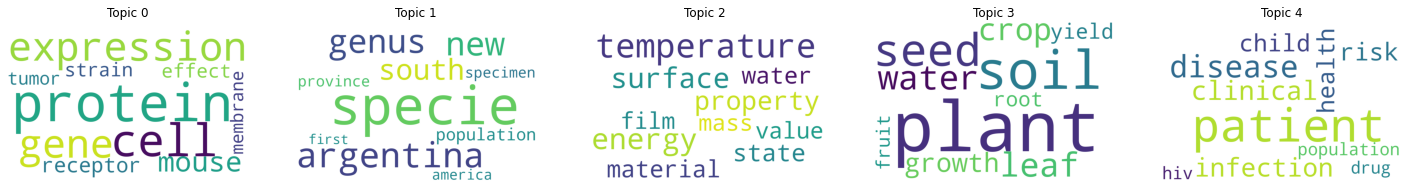



----------> 2012 <----------


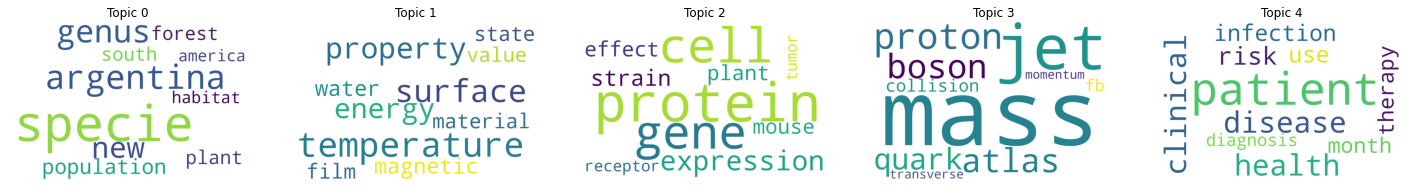



----------> 2013 <----------


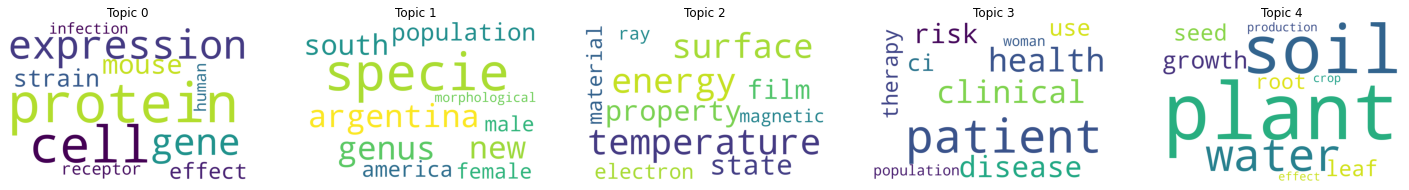



----------> 2014 <----------


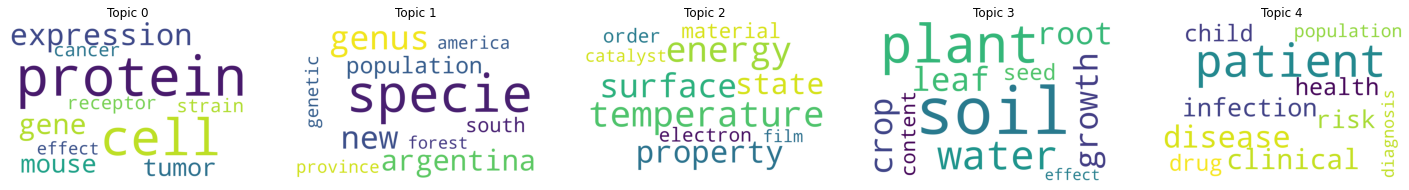



----------> 2015 <----------


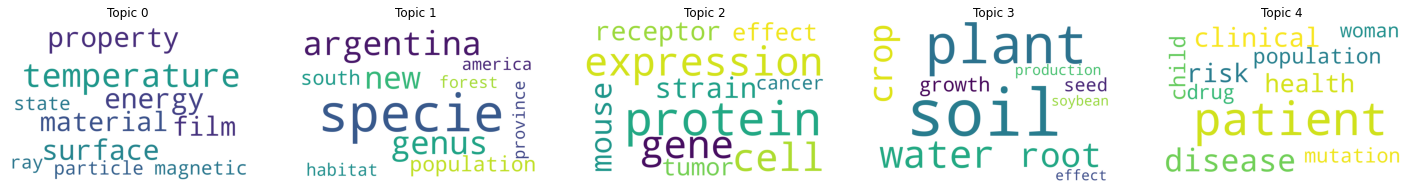



----------> 2017 <----------


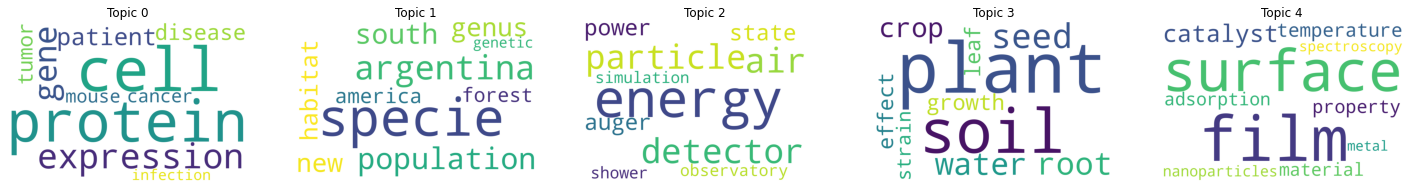

In [ ]:
dict_key_nmf = defaultdict(list)
nmf_wordcloud(dict_resumen_anios_papers, 5)